In [311]:
from copy import copy, deepcopy
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.optimize import minimize
import pylab
import matplotlib.pyplot as plt
import matplotlib.animation
from mpl_toolkits.mplot3d import Axes3D
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization.bloch import Bloch
from IPython.display import HTML

#### Problem 1
Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.

In [2]:
def Rx(theta):
    return np.array([[np.cos(theta/2), -1j * np.sin(theta/2)], [-1j * np.sin(theta/2), np.cos(theta/2)]])

def Rz(phi):
    return np.array([[np.exp(-0.5j * phi), 0], [0, np.exp(0.5j * phi)]])

def circuit_embeding(parameters, initial_state = np.array([1, 0])[:, np.newaxis]): # parameters[0] = theta, parameters[1] = phi
    state = initial_state
    state = np.matmul(Rz(parameters[1]), np.matmul(Rx(parameters[0]), state))
    return state

def qstate_to_bloch_vector(state):
    dm = np.matmul(state, state.conj().T)
    bloch_vector = np.array([2 * dm[0, 1].real, 2 * dm[1, 0].imag, dm[0, 0] - dm[1, 1]]).real
    return bloch_vector

def create_parameter_trajectory(t_list, *args):
    return np.array([f(t_list) for f in args]).T

In [3]:
def sweep_on_bloch_sphere():
    def f_theta(t_list):
        return 2 * np.pi * t_list

    def f_phi(t_list):
        return 20 * np.pi * t_list
    
    def update_bloch_sphere(idx, traj):
        ax.clear()
        plot_bloch_vector(qstate_to_bloch_vector(circuit_embeding(traj[idx])), ax = ax)
        
    traj = create_parameter_trajectory(np.linspace(0, 1, 100), *[f_theta, f_phi])
    fig = plot_bloch_vector(qstate_to_bloch_vector(circuit_embeding(traj[0])))
    ax = fig.gca()
    ani = matplotlib.animation.FuncAnimation(fig, update_bloch_sphere, frames = np.arange(100), interval=30, blit=False, repeat = True, fargs = (traj,))
    HTML(ani.to_html5_video())
    return ani

In [4]:
animation = sweep_on_bloch_sphere()

In [16]:
HTML(animation.to_html5_video())

#### Problem 2
Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.

In [5]:
def swap_test(state1, state2):
    zero_state = np.array([1, 0])[:, np.newaxis]
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    I = np.eye(2)
    Z = np.array([[1, 0], [0, -1]])
    CSWAP = np.eye(8)
    CSWAP[5, 5] = 0
    CSWAP[6, 6] = 0
    CSWAP[5, 6] = 1
    CSWAP[6, 5] = 1
    
    state = np.kron(np.kron(zero_state, state1), state2)
    state = np.matmul(np.kron(np.kron(H, I), I), state)
    state = np.matmul(CSWAP, state)
    state = np.matmul(np.kron(np.kron(H, I), I), state)
    return 1 - np.matmul(np.matmul(state.conj().T, np.kron(np.kron(Z, I), I)), state)[0, 0].real # 0 for same two state and 1 for orthogonal state

In [6]:
def loss_val(parameter, random_state, optimization_traj = []):
    optimization_traj.append(copy(parameter))
    current_state = circuit_embeding(parameter)
    return swap_test(current_state, random_state)

In [7]:
def show_optimization_trajectory_on_bloch_sphere(optimization_traj, figsize = (5, 5), view = (-60, 30)):
    def update(idx, trajectory):
        ax.clear()
        B = Bloch(axes=ax)
        B.add_vectors(trajectory[idx])
        B.add_vectors(qstate_to_bloch_vector(random_state))
        if idx > 10:
            B.add_points(np.array(trajectory[idx - 10:idx]).T)
        elif idx > 0:
            B.add_points(np.array(trajectory[:idx]).T)
        B.render(title=None)
        
    fig = plt.figure(figsize=figsize)
    ax = Axes3D(fig, azim=view[0], elev=view[1])
    ax.set_axis_off()
    ax.set_xlim3d(-0.7, 0.7)
    ax.set_ylim3d(-0.7, 0.7)
    ax.set_zlim3d(-0.7, 0.7)
    
    fig.set_size_inches(figsize[0], figsize[1])
    trajectory_on_Bloch_sphere = np.array([qstate_to_bloch_vector(circuit_embeding(point)) for point in optimization_traj])
    ani = matplotlib.animation.FuncAnimation(fig, 
                                             update, 
                                             frames = np.arange(len(trajectory_on_Bloch_sphere)), 
                                             interval=50, blit=False, repeat = False, 
                                             fargs = (trajectory_on_Bloch_sphere,))
    return ani

In [ ]:
# randomly generated quantum state: random_state
random_parameter = 2 * np.pi * np.random.random(2)
random_state = circuit_embeding(random_parameter)
optimization_traj = []
res = minimize(loss_val, np.array([0, 0]), method='nelder-mead', args = (random_state, optimization_traj, ))
print(res.success)
print("answer: " + str(random_parameter))
print("optimized solution: " + str(res.x))
animation = show_optimization_trajectory_on_bloch_sphere(optimization_traj)
HTML(animation.to_html5_video())

#### Problem 3
Suppose you are given with a random state, made by N qubits, for which you only know that it is a product state and each of the qubits are in the state | 0 > or | 1>. By product state we mean that it can be written as the product of single qubit states, without the need to do any summation. 

For example, the state
|a> = |01>
Is a product state, while the state
|b> = |00> + |11>
Is not.

Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.


In [8]:
def N_qubit_embeding(parameters, initial_states = None): # parameters[:, 0] = theta, parameters[:, 1] = phi
    if not initial_states:
        initial_states = np.array([1, 0])[:, np.newaxis][np.newaxis, :].repeat(len(parameters), axis = 0)
    state = circuit_embeding(parameters[0], initial_states[0])
    for parameter, initial_state in zip(parameters[1:], initial_states[1:]):
        state = np.kron(state, circuit_embeding(parameter, initial_state))
        
    return state

In [9]:
def apply_CSWAP(state, target_index1, target_index2, CSWAPs = {}):
    CSWAP = None
    if (target_index1, target_index2) in CSWAPs:
        CSWAP = CSWAPs[(target_index1, target_index2)]
    elif (target_index2, target_index1) in CSWAPs:
        CSWAP = CSWAPs[(target_index2, target_index1)]
    else:
        N = len(state)      # number of basis
        n = int(np.log2(N)) # number of qubits
        
        if n > 10:
            CSWAP = sparse.lil_matrix(np.eye(len(state)))
        else:
            CSWAP = np.eye(len(state))
            
        fixed_qubit_idxes = list(range(1, n))
        fixed_qubit_idxes.remove(target_index1)
        fixed_qubit_idxes.remove(target_index2)
        for i in range(2**len(fixed_qubit_idxes)): # number of fixed qubits while applying swap gate (except control qubit)
            binary = np.zeros(n, dtype = int)
            binary[0] = 1
            binary[fixed_qubit_idxes] = [int(x) for x in bin(i)[2:].zfill(len(fixed_qubit_idxes))]
            binary[target_index1] = 1
            binary_string1 = [str(x) for x in binary]
            swap_index1 = int('0b' + ''.join(binary_string1), 2)

            binary[target_index1] = 0
            binary[target_index2] = 1
            binary_string2 = [str(x) for x in binary]
            swap_index2 = int('0b' + ''.join(binary_string2), 2)
            CSWAP[:, [swap_index1, swap_index2]] = CSWAP[:, [swap_index2, swap_index1]]
        CSWAPs[(target_index1, target_index2)] = CSWAP
        print("create CSWAP for " + str(target_index1) + ", " + str(target_index2))
    return CSWAP.dot(state)

In [10]:
def N_qubit_swap_test(state1, state2):
    zero_state = np.array([1, 0])[:, np.newaxis]
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    I = np.eye(len(state1))
    Z = np.array([[1, 0], [0, -1]])
    N = len(state1)
    n = int(np.log2(N)) # number of qubits
    state = np.matmul(H, zero_state)
    state = np.kron(np.kron(state, state1), state2)
    for i in range(n):
        state = apply_CSWAP(state, 1 + i, 1 + n + i, CSWAPs)
    state = np.matmul(np.kron(np.kron(H, I), I), state)
    return 1 - np.matmul(np.matmul(state.conj().T, np.kron(np.kron(Z, I), I)), state)[0, 0].real # 0 for same two state and 1 for orthogonal state

In [11]:
def N_qubit_loss_val(parameter, random_state, optimization_traj = []):
    if parameter.ndim == 1:
        parameter = parameter.reshape((len(parameter)//2, 2))
    optimization_traj.append(copy(parameter))
    current_state = N_qubit_embeding(parameter)
    return N_qubit_swap_test(current_state, random_state)

In [12]:
def show_N_qubit_optimization_trajectory_on_bloch_sphere(optimization_traj, figsize = (5, 5), view = (-60, 30)):
    axs = []
    n_qubits = len(optimization_traj[0])
    
    figure_array_shape = (1, n_qubits)
    if n_qubits > 4:
        figure_array_shape = (n_qubits//4 + 1, 4)
        
    figsize = (figsize[0] * figure_array_shape[1], figsize[1] * figure_array_shape[0])
    
    
    def update(idx, trajectories):
        for qubit_idx, trajectory in enumerate(trajectories):
            axs[qubit_idx].clear()
            B = Bloch(axes=axs[qubit_idx])
            B.add_vectors(trajectory[idx])
            B.add_vectors(qstate_to_bloch_vector(decomposed_random_state[qubit_idx]))
            if idx > 10:
                B.add_points(np.array(trajectory[idx - 10:idx]).T)
            elif idx > 0:
                B.add_points(np.array(trajectory[:idx]).T)
            B.render(title=None)
        
    fig = plt.figure(figsize=figsize)
    

    
    for i in range(n_qubits):
        axs.append(fig.add_subplot(figure_array_shape[0], figure_array_shape[1], i+1, projection='3d'))
        axs[-1].set_axis_off()
        axs[-1].set_xlim3d(-0.7, 0.7)
        axs[-1].set_ylim3d(-0.7, 0.7)
        axs[-1].set_zlim3d(-0.7, 0.7)

    fig.set_size_inches(figsize[0], figsize[1])
    trajectories_on_Bloch_sphere = [np.array([qstate_to_bloch_vector(circuit_embeding(point)) for point in one_optimization_traj]) for one_optimization_traj in np.array(optimization_traj).transpose(1, 0, 2)]
    ani = matplotlib.animation.FuncAnimation(fig, 
                                             update, 
                                             frames = np.arange(len(trajectories_on_Bloch_sphere[0])), 
                                             interval=50, blit=False, repeat = False, 
                                             fargs = (trajectories_on_Bloch_sphere,))
    return ani

In [552]:
number_of_qubits = 1
# randomly generated quantum state:  random_state
random_parameters = 2 * np.pi * np.random.random((number_of_qubits, 2))
random_state = N_qubit_embeding(random_parameters)
decomposed_random_state = [circuit_embeding(random_parameter) for random_parameter in random_parameters]
optimization_traj = []
res = minimize(N_qubit_loss_val, np.zeros((number_of_qubits, 2)), method='cobyla', args = (random_state, optimization_traj))
print(res.success)
print("answer: " + str(random_parameters))
print("optimized solution: " + str(res.x))

^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
True
answer: [[6.14549695 1.25125391]]
optimized solution: [[6.96507180e-05 9.99928245e-01]]


207


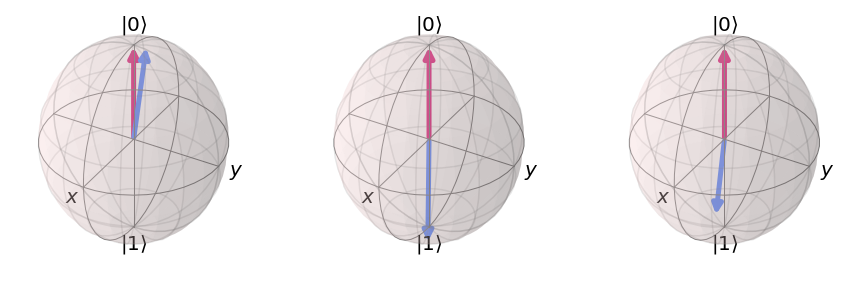

In [55]:
number_of_animation_frame = 200
reduced_optimization_traj = np.array(optimization_traj)[::len(optimization_traj) // number_of_animation_frame if len(optimization_traj) > number_of_animation_frame else 1]
print(len(reduced_optimization_traj))
animation = show_N_qubit_optimization_trajectory_on_bloch_sphere(reduced_optimization_traj)
HTML(animation.to_html5_video())

### 2. CSWAP without matrix operation

In [13]:
def apply_CSWAP(state, target_index1, target_index2, CSWAPs = {}):
    N = len(state)      # number of basis
    n = int(np.log2(N)) # number of qubits

    swap_idx = np.arange(n-1)
    swap_idx[target_index1 - 1], swap_idx[target_index2 - 1] = swap_idx[target_index2 - 1], swap_idx[target_index1 - 1]
    state[N//2:] = state.reshape([2]*n)[1].transpose(swap_idx).reshape((2**(n-1),1))
    return state

In [14]:
def N_qubit_swap_test(state1, state2, CSWAPs = {}):
    zero_state = np.array([1, 0])[:, np.newaxis]
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    N = len(state1)
    n = int(np.log2(N)) # number of qubits
    state = np.matmul(H, zero_state)
    state = np.kron(np.kron(state, state1), state2)
    for i in range(n):
        state = apply_CSWAP(state, 1 + i, 1 + n + i, CSWAPs)
    processed_state = deepcopy(state)
    length = len(processed_state)
    processed_state[:length//2] = (state[:length//2] + state[length//2:])/np.sqrt(2)
    processed_state[length//2:] = (state[:length//2] - state[length//2:])/np.sqrt(2)
    transposed_state = deepcopy(processed_state).T.conj()
    processed_state[length//2:] *= -1
    return_value = 1 - np.matmul(transposed_state, processed_state).real
    return return_value # 0 for two identical states and 1 for orthogonal states


In [553]:
number_of_qubits = 1
# randomly generated quantum state:  random_state
random_parameters = 2 * np.pi * np.random.random((number_of_qubits, 2))
random_state = N_qubit_embeding(random_parameters)
decomposed_random_state = [circuit_embeding(random_parameter) for random_parameter in random_parameters]
optimization_traj = []

res = minimize(N_qubit_loss_val, np.zeros((number_of_qubits, 2)), method='COBYLA', args = (random_state, optimization_traj), tol=1e-2)
print(res.success)
print("answer: " + str(random_parameters))
print("optimized solution: " + str(res.x))

^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
^^^^
(1, 2)
(2, 1)
(2,)
True
answer: [[4.71136391 1.07585184]]
optimized solution: [[1.00848631 0.00528985]]


287


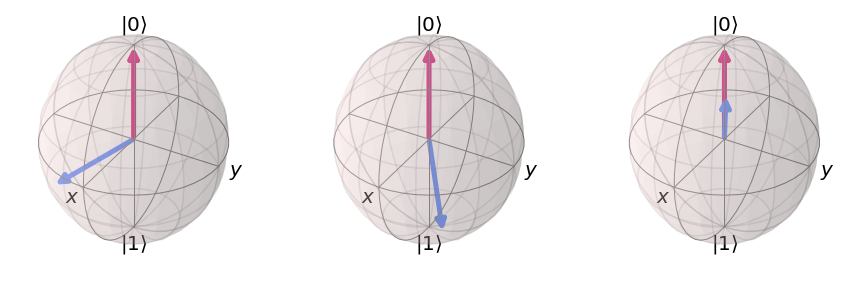

In [17]:
number_of_animation_frame = 200
reduced_optimization_traj = np.array(optimization_traj)[::len(optimization_traj) // number_of_animation_frame if len(optimization_traj) > number_of_animation_frame else 1]
print(len(reduced_optimization_traj))
animation = show_N_qubit_optimization_trajectory_on_bloch_sphere(reduced_optimization_traj)
HTML(animation.to_html5_video())

### 3. CSWAP with reduced quantum state

Lastly, I changed the structure of the state vector to reduce the space complexity. Generally, (2n+1) qubits are required for the n qubit SWAP test. However, since the problem restricted the target state as the product state, the state does not need to have the structure of C^x(2n+1). By considering the qubits' entanglement relations, I observed that only a small subspace of it, C^2 x [+n (C^2 x C^2)], is required. The size of the state vector was then reduced significantly from $ 2^{(2n+1)} $ to 8n. 

In [554]:
def N_qubit_embeding_product_state(parameters, initial_states = None): # parameters[:, 0] = theta, parameters[:, 1] = phi
    if not initial_states:
        initial_states = np.array([1, 0])[:, np.newaxis][np.newaxis, :].repeat(len(parameters), axis = 0)
    states = []
    for parameter, initial_state in zip(parameters, initial_states):
        states.append(circuit_embeding(parameter, initial_state))
    state = np.array(states).reshape((len(states), 2))/np.sqrt(len(parameters))
    return state

In [555]:
def apply_CSWAP_product_state(state, target_index):
    N = len(state)      # number of basis
    n = N//8 # number of qubits
    state = state.reshape((2, n, 2, 2))
    state[1, target_index] = state[1, target_index].transpose()
    state = state.reshape((N))
    return state

In [556]:
def N_qubit_SWAP_test_product_state(state1, state2):
    zero_state = np.array([1, 0])[:, np.newaxis]
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    N = len(state1)
    n = N # int(np.log2(N)) # number of qubits

    zero_state = np.matmul(H, zero_state).flatten()
    state = []

    for qubit1, qubit2 in zip(state1, state2):
        state.append(np.kron(qubit1, qubit2))

    state = np.array(state).flatten()
    state = np.kron(zero_state, state)
    for i in range(n):
        state = apply_CSWAP_product_state(state, i)
    processed_state = deepcopy(state)
    length = len(processed_state)
    processed_state[:length//2] = (state[:length//2] + state[length//2:])/np.sqrt(2)
    processed_state[length//2:] = (state[:length//2] - state[length//2:])/np.sqrt(2)
    transposed_state = processed_state.T.conj()
    processed_state[length//2:] *= -1
    
    return_value = 1 - np.matmul(transposed_state, processed_state).real
    return return_value # 0 for two identical states and 1 for orthogonal states


In [557]:
def N_qubit_loss_val_product_state(parameter, random_state, optimization_traj = []):
    if parameter.ndim == 1:
        parameter = parameter.reshape((2, len(parameter)//2)).T
    optimization_traj.append(copy(parameter))
    current_state = N_qubit_embeding_product_state(parameter)
    return N_qubit_SWAP_test_product_state(current_state, random_state)

In [558]:
def fideltity_two_qubits(state1, state2):
    return abs(np.matmul(state1.T.conj(), state2))**2

In [562]:
number_of_qubits = 1
# randomly generated quantum state:  random_state
random_parameters = 2 * np.pi * np.random.random((number_of_qubits, 2))
random_state = N_qubit_embeding_product_state(random_parameters)
decomposed_random_state = [circuit_embeding(random_parameter) for random_parameter in random_parameters]
optimization_traj = []
res = minimize(N_qubit_loss_val_product_state, np.zeros((number_of_qubits, 2)), method='COBYLA', args = (random_state, optimization_traj)) # , tol=1e-4, options={'maxiter': 3000})
print(res.success)
print("answer: \n" + str(random_parameters[:, 0]%(np.pi)))
print("\n" + str(random_parameters[:, 1]%(2 * np.pi)))
print("optimized solution: \n" + str(res.x[:, 0]%(np.pi)))
print("\n" + str(res.x[:, 1]%(2 * np.pi)))

True
answer: 
[1.24248055]

[5.17029045]
optimized solution: 
[1.24238859]

[5.17023993]


In [560]:
N_qubit_range = 100
N_iter = 7
N_qubits = np.arange(1, N_qubit_range + 1)
mean_fidelity = np.zeros_like(N_qubits, dtype = float)
std_fidelity = np.zeros_like(N_qubits, dtype = float)

for n in N_qubits:
    print(str(n) + "qubit SWAP test")
    fidelities = []
    for i in range(N_iter):
        # randomly generated quantum state:  random_state
        random_parameters = 2 * np.pi * np.random.random((n, 2))
        random_state = N_qubit_embeding_product_state(random_parameters)
        # decomposed_random_state = [circuit_embeding(random_parameter) for random_parameter in random_parameters]
        optimization_traj = []
        res = minimize(N_qubit_loss_val_product_state, np.zeros((n, 2)), method='COBYLA', args = (random_state, optimization_traj), tol=1e-4) #, options={'maxiter': 3000})
        for res_param, random_parameter in zip(res.x, random_parameters):  
            fid = fideltity_two_qubits(circuit_embeding(res_param).flatten(), circuit_embeding(random_parameter).flatten())
            fidelities.append(fid)
    mean_fidelity[n-1] = np.mean(fidelities)
    std_fidelity[n-1] = np.std(fidelities)

1qubit SWAP test
2qubit SWAP test
3qubit SWAP test
4qubit SWAP test


KeyboardInterrupt: 

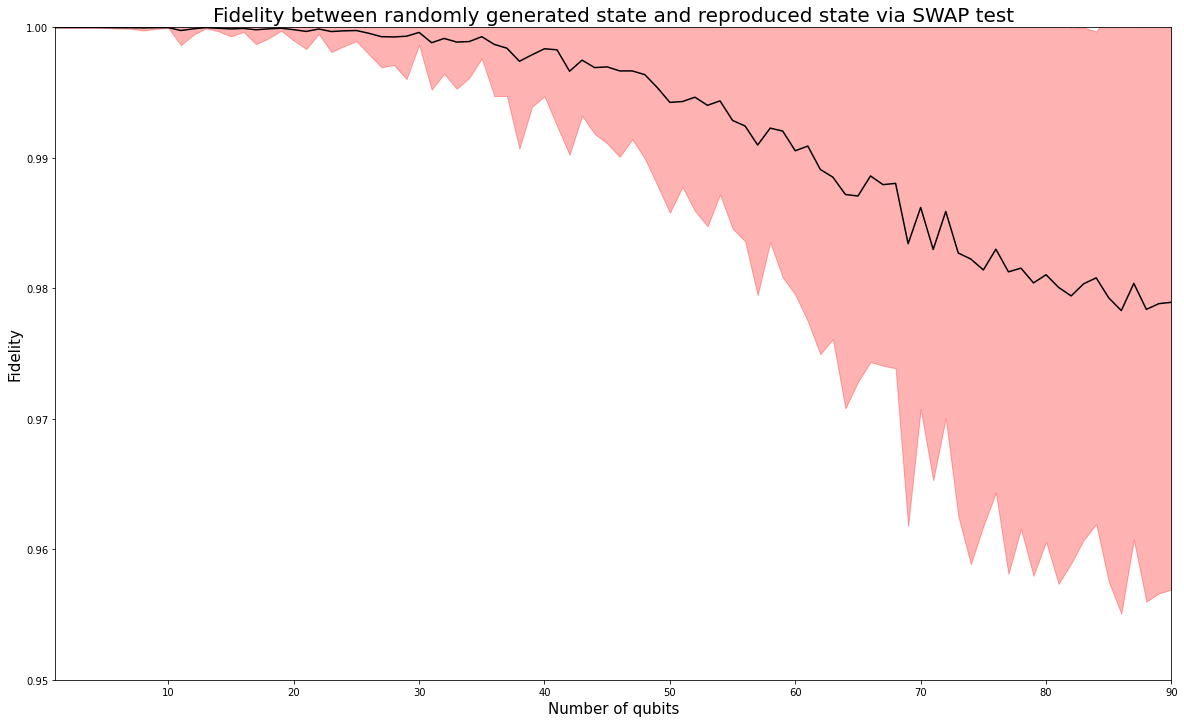

In [551]:
fig = plt.figure(figsize=(20, 12))
ax = fig.subplots()
ax.set_xlabel('Number of qubits', fontsize=15)
ax.set_ylabel('Fidelity', fontsize=15)
ax.set_title('Fidelity between randomly generated state and reproduced state via SWAP test', fontsize=20)

# color = ax._get_lines.color_cycle.next()

max_idx = 90

ax.plot(N_qubits[:max_idx], mean_fidelity[:max_idx], color = 'black') # , color=color)
ax.fill_between(N_qubits[:max_idx], mean_fidelity[:max_idx] + std_fidelity[:max_idx], mean_fidelity[:max_idx] - std_fidelity[:max_idx], color='red', alpha=0.3)
plt.axis([N_qubits[0], N_qubits[max_idx-1], 0.95, 1])
fig.savefig('images/fidelities.png')

In [528]:
mean_fidelity[max_idx] + std_fidelity[max_idx]

1.0009519497835682

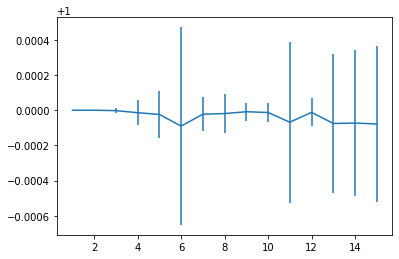

In [497]:
plt.errorbar(N_qubits, mean_fidelity, yerr=std_fidelity, yr)
plt.show()

17


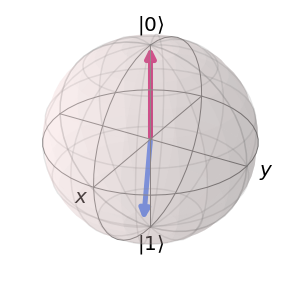

In [563]:
number_of_animation_frame = 15
reduced_optimization_traj = np.array(optimization_traj)[::len(optimization_traj) // number_of_animation_frame if len(optimization_traj) > number_of_animation_frame else 1]
print(len(reduced_optimization_traj))
animation = show_N_qubit_optimization_trajectory_on_bloch_sphere(reduced_optimization_traj)
HTML(animation.to_html5_video())